In [ ]:
# Importing packages

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2

from PIL import Image
import pickle

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#Image loading and preprocessing, the function return a preprocessed image tensor
def load_and_preprocess_image(image_path):

    #img=tf.strings.as_string(image_path)
    img=tf.io.read_file(image_path)

    #Decode the JPEG image to a tensor
    img=tf.image.decode_jpeg(img)

    #Normalize pixel values to the range [0, 1]
    img=img/255

    #Resize the image to a fixed size (64x64 pixels)
    img=tf.image.resize(img, [64,64])

    #Convert the image tensor to float32 data type
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    
    return img

# This function loads and preprocesses a label from the given label_path
def load_and_preprocess_label(label_path):
    # Read the label file as a string
    label=tf.io.read_file(label_path)

    # Convert the string label to a numerical value
    label=tf.strings.to_number(label)

    # Normalize the label
    label=label/1000

    #Convert the label tensor to float32 data type
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    return label


window_size = 120  # Define the window size
stride = 136 

y=[]
for ds in tf.data.Dataset.list_files("test_seq/*/labels/*", shuffle=False).map(load_and_preprocess_label).window(16, shift=136, drop_remainder=True).take(2205):
    for element in ds:
        #print(element.numpy())
        y.append(element.numpy())
    #print("Move")

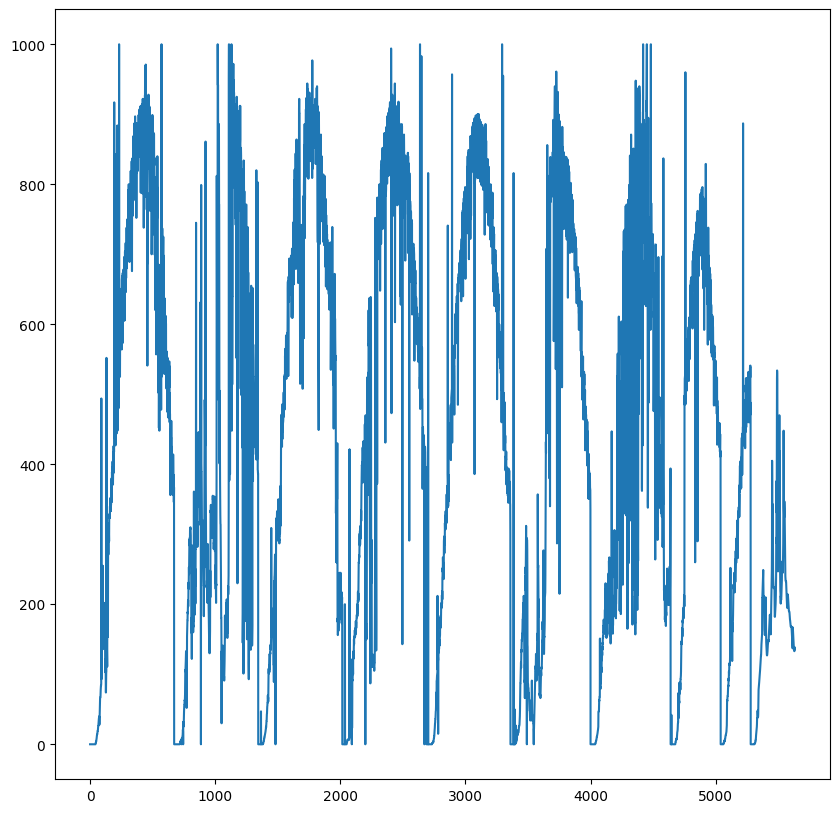

In [ ]:
plt.plot(y)

**Building data pipeline**

In [ ]:
def load_and_preprocess_image(image_path):
    img=tf.io.read_file(image_path)
    img=tf.image.decode_jpeg(img)
    img=img/255
    img=tf.image.resize(img, [64,64])
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    
    return img

def load_and_preprocess_label(label_path):
    label=tf.io.read_file(label_path)
    label=tf.strings.to_number(label)
    label=label/1000
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    return label


window_size = 120  # Define the window size
stride = 136 

#Pipeline construction for validation image sequences
val_img_dataset=tf.data.Dataset.list_files("val_data_seq/*/images/*", shuffle=False)
val_img_dataset=val_img_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_img_dataset=val_img_dataset.window(window_size, shift=stride, drop_remainder=True).flat_map(lambda x: x.batch(window_size))
val_img_dataset=val_img_dataset.batch(16).cache('val_cache_img_folderr').prefetch(tf.data.AUTOTUNE)

#Pipeline construction for validation label sequences
val_label_dataset=tf.data.Dataset.list_files("val_data_seq/*/labels/*", shuffle=False)
val_label_dataset=val_label_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(window_size, shift=stride, drop_remainder=True)
val_label_dataset=val_label_dataset.flat_map(lambda x: x.batch(window_size))
val_label_dataset=val_label_dataset.batch(16).cache('val_cache_lbl_folderr').prefetch(tf.data.AUTOTUNE)

#Pipeline construction for validation target sequences
val_forecast_dataset=tf.data.Dataset.list_files("val_data_seq/*/labels/*", shuffle=False).skip(120)
val_forecast_dataset=val_forecast_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(16, shift=stride, drop_remainder=True)
val_forecast_dataset=val_forecast_dataset.flat_map(lambda x: x.batch(16))
val_forecast_dataset=val_forecast_dataset.batch(16).cache('val_cache_forecast_folderr_2').prefetch(tf.data.AUTOTUNE)


#Pipeline construction for train image sequences
img_dataset=tf.data.Dataset.list_files("data_seq/*/images/*", shuffle=False)
img_dataset=img_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
img_dataset=img_dataset.window(window_size, shift=stride, drop_remainder=True).flat_map(lambda x: x.batch(window_size))
img_dataset=img_dataset.batch(16).cache('cache_img_folderr').prefetch(tf.data.AUTOTUNE)

#Pipeline construction for train label sequences
label_dataset=tf.data.Dataset.list_files("data_seq/*/labels/*", shuffle=False)
label_dataset=label_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(window_size, shift=stride, drop_remainder=True)
label_dataset=label_dataset.flat_map(lambda x: x.batch(window_size))
label_dataset=label_dataset.batch(16).cache('cache_lbl_folderr').prefetch(tf.data.AUTOTUNE)

#Pipeline construction for train target sequences
forecast_dataset=tf.data.Dataset.list_files("data_seq/*/labels/*", shuffle=False).skip(120)
forecast_dataset=forecast_dataset.map(load_and_preprocess_label, num_parallel_calls=tf.data.AUTOTUNE).window(16, shift=stride, drop_remainder=True)
forecast_dataset=forecast_dataset.flat_map(lambda x: x.batch(16))
forecast_dataset=forecast_dataset.batch(16).cache('cache_forecast_folderr_2').prefetch(tf.data.AUTOTUNE)


'for sequences_dataset in img_dataset.take(1):\n    print(sequences_dataset.shape)\n    print("ok")'

In [ ]:
# Define the window size and stride for dataset processing
window_size = 120 
stride = 136  # Stride for moving the window

# Create a dataset for loading and preprocessing test images
test_img_dataset = tf.data.Dataset.list_files("test_seq/*/images/*", shuffle=False)
test_img_dataset = test_img_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Divide the dataset into non-overlapping windows of specified window_size with a specified stride
test_img_dataset = test_img_dataset.window(window_size, shift=stride, drop_remainder=True)

# Flatten the nested windows to form a single sequence of images
test_img_dataset = test_img_dataset.flat_map(lambda x: x.batch(window_size))

# Batch the images (group them into batches of size 8)
test_img_dataset = test_img_dataset.batch(8)

# Cache the dataset in memory for faster retrieval
test_img_dataset = test_img_dataset.cache('test_cache_img_folder')

# Prefetch the data to optimize loading
test_img_dataset = test_img_dataset.prefetch(tf.data.AUTOTUNE)

# Create a dataset for loading and preprocessing test labels
test_label_dataset = tf.data.Dataset.list_files("test_seq/*/labels/*", shuffle=False)
test_label_dataset = test_label_dataset.map(load_and_preprocess_label)
test_label_dataset = test_label_dataset.window(window_size, shift=stride, drop_remainder=True)
test_label_dataset = test_label_dataset.flat_map(lambda x: x.batch(window_size))
test_label_dataset = test_label_dataset.batch(8)
test_label_dataset = test_label_dataset.cache('test_cache_lbl_folder')

# Prefetch the data to optimize loading
test_label_dataset = test_label_dataset.prefetch(tf.data.AUTOTUNE)


# 1- **Model 1**

In [4]:
model_1=tf.keras.models.load_model(r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\Final models\forecasting using img+pirp\usin conv + lstm + bidirec gru + 4,5M param\model.338-0.08.h5")
model_1.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 120, 64, 64  0           []                               
                                , 3)]                                                             
                                                                                                  
 input_24 (InputLayer)          [(None, 120, 1)]     0           []                               
                                                                                                  
 time_distributed_91 (TimeDistr  (None, 120, 62, 62,  1792       ['input_23[0][0]']               
 ibuted)                         64)                                                              
                                                                                            

In [ ]:
#model=tf.keras.models.load_model("Final models\\forecasting using img+pirp\\using CONV2D + LSTM\\forecast_model.h5")
#model_1=tf.keras.models.load_model("forecast.4.5M param.h5")

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models_seq_forecast_1_8",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mean_absolute_error'], run_eagerly=True)


num_epochs = 1000

train_data= tf.data.Dataset.zip((img_dataset, label_dataset))
train_data_2=tf.data.Dataset.zip((train_data, forecast_dataset))

val_data= tf.data.Dataset.zip((val_img_dataset, val_label_dataset))
val_data_2=tf.data.Dataset.zip((val_data, val_forecast_dataset))


model_1.fit(train_data_2, validation_data=val_data_2, epochs=num_epochs, callbacks=my_callbacks, verbose=1)

Epoch 1/1000
261/261 [==============================] - 83s 294ms/step - loss: 0.0883 - mean_absolute_error: 0.0883 - val_loss: 0.1742 - val_mean_absolute_error: 0.1742
Epoch 2/1000
261/261 [==============================] - 74s 283ms/step - loss: 0.0647 - mean_absolute_error: 0.0647 - val_loss: 0.1589 - val_mean_absolute_error: 0.1589
Epoch 3/1000
261/261 [==============================] - 74s 282ms/step - loss: 0.0591 - mean_absolute_error: 0.0591 - val_loss: 0.1545 - val_mean_absolute_error: 0.1545
Epoch 4/1000
261/261 [==============================] - 74s 282ms/step - loss: 0.0575 - mean_absolute_error: 0.0575 - val_loss: 0.1259 - val_mean_absolute_error: 0.1259
Epoch 5/1000
261/261 [==============================] - 72s 276ms/step - loss: 0.0551 - mean_absolute_error: 0.0551 - val_loss: 0.1177 - val_mean_absolute_error: 0.1177
Epoch 6/1000
261/261 [==============================] - 73s 278ms/step - loss: 0.0519 - mean_absolute_error: 0.0519 - val_loss: 0.1062 - val_mean_absolute_

In [ ]:
loss_0=model_1.history.history['loss']
val_loss_0=model_1.history.history['val_loss']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


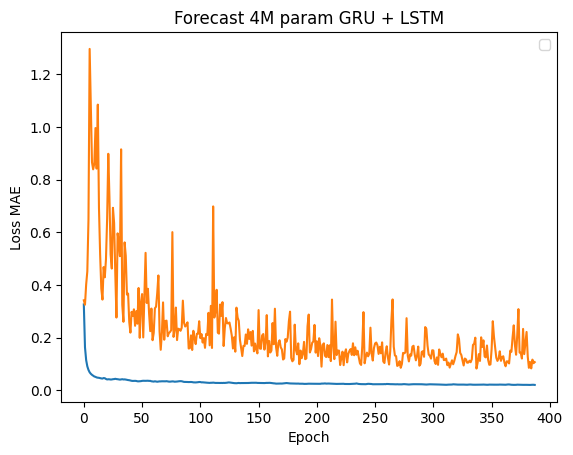

In [ ]:
#I trained the model twice and then added the losses

loss=model_1.history.history['loss']
val_loss=model_1.history.history['val_loss']

plt.plot(loss_0+loss)
plt.plot(val_loss_0+val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss MAE')
plt.legend()
plt.title('Forecast 4M param GRU + LSTM')
plt.show()